In [385]:
from pydicom import dcmread
import matplotlib.pylab as plt
import numpy as np
import os
import skimage as ski
from skimage.transform import warp, AffineTransform, pyramid_expand, pyramid_reduce
import cv2
import scipy
# from skimage.filters import unsharp_mask
from natsort import natsorted
from skimage.exposure import match_histograms
# from sklearn.mixture import GaussianMixture
from skimage.registration import phase_cross_correlation
from scipy.signal import find_peaks
from scipy import ndimage as scp
from tqdm import tqdm
# from skimage.metrics import normalized_root_mse as nrm
# from statsmodels.tsa.stattools import acf
import pickle
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
from scipy.fftpack import fft2, fftshift, ifft2, fft, ifft, ifftshift
import time
import math
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
# from skimage.feature import SIFT, match_descriptors,plot_matches
# from skimage.feature import ORB
import ants.registration as ants_register
import ants
from scipy.optimize import minimize as minz
# from scipy.optimize import dual_annealing,fmin_powell
from scipy import optimize
import pickle
from skimage.filters import threshold_otsu
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import mean_squared_error as mse
# from tifffile import imread as tiffread
import sys
from util_funcs import *
import h5py
from ultralytics import YOLO
from collections import defaultdict

In [386]:
path = f'batch1_endo/scan2/'
# path = '/Users/akapatil/Documents/OCT/IR_card_glass_side_3_13_2025_without_shift_correction/scan5/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.h5'):
        pic_paths.append(i)
with h5py.File(path+pic_paths[0], 'r') as hf:
    original_data = hf['volume'][:,100:-100,:]

# original_data = original_data[:,150:650,:]
# def load_data_dcm(path_num,path_all = False):
#     path = path_num
#     pic_paths = []
#     for i in os.listdir(path):
#         if i.endswith('.dcm') or  i.endswith('.tiff') or i.endswith('.PNG'):
#             pic_paths.append(i)
#     pic_paths = natsorted(pic_paths)
#     temp_img = dcmread(path+pic_paths[0]).pixel_array
#     imgs_from_folder = np.zeros((len(pic_paths),*temp_img.shape))
#     for i,j in enumerate(pic_paths):
#         aa = dcmread(path+j)
#         imgs_from_folder[i] = aa.pixel_array
#     imgs_from_folder = imgs_from_folder.astype(np.float32)
#     return imgs_from_folder

In [387]:
model = YOLO('/Users/akapatil/Documents/feature_extraction/yolo_feature_extraction/yolov12s_best.pt')

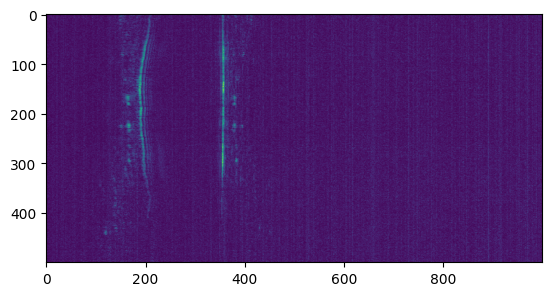

In [388]:
plt.imshow(original_data[:,:,100])

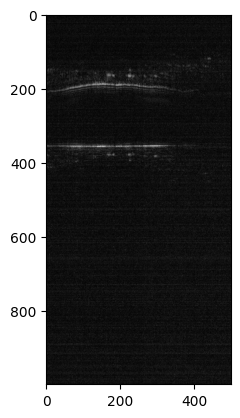

In [389]:
plt.imshow(preprocess_img(original_data[:,:,100]))

In [390]:
static_flat = np.argmax(np.sum(original_data[:,:,:],axis=(0,1)))
test_detect_img = preprocess_img(original_data[:,:,static_flat])
res = model.predict(test_detect_img,iou = 0.5, save = False, verbose=False,classes=0)
result_list = res[0].summary()

grouped = defaultdict(list)
for item in result_list:
    grouped[item['name']].append(item)

filtered_summary = []
for group in grouped.values():
    top_two = sorted(group, key=lambda x: x['confidence'], reverse=True)[:2]
    filtered_summary.extend(top_two)
 
result_list = filtered_summary

In [391]:

if len(result_list)>0:
    surface_coords = []
    for surfaces in result_list:
        surface_coords.append([int(surfaces['box']['y1'])-20,int(surfaces['box']['y2'])+20])
    if len(surface_coords)>1:
        surface_coords = np.sort(surface_coords,axis=0)

In [392]:
surface_coords

array([[154, 261],
       [317, 392]])

In [162]:
# sum_img = np.max(original_data[:,:,:],axis=2)
# peaks = find_peaks(np.sum(sum_img,axis=0),distance = 30)[0]
# enface_extraction_rows = peaks[np.argsort(np.sum(sum_img,axis=0)[peaks])[-2:]]
# enface_extraction_rows = np.sort(enface_extraction_rows)
# print('ROWS:',enface_extraction_rows)
# UP,DOWN = enface_extraction_rows.min()-50,enface_extraction_rows.min()+50
# UP = max(UP,0)
# DOWN = min(DOWN, original_data.shape[2])
# UP,DOWN

# Flat

In [163]:
def mse_fun_tran_flat(shif, x, y , past_shift):
    x = warp(x, AffineTransform(translation=(-past_shift,0)),order=1)
    y = warp(y, AffineTransform(translation=(past_shift,0)),order=1)

    warped_x_stat = warp(x, AffineTransform(translation=(-shif[0],0)),order=1)
    warped_y_mov = warp(y, AffineTransform(translation=(shif[0],0)),order=1)

    return (1-ncc(warped_x_stat ,warped_y_mov))
    
def ants_all_tran_flat(data,UP,DOWN,static_flat):
    transforms_all = np.tile(np.eye(3),(data.shape[2],1,1))
    for i in tqdm(range(data.shape[2]),desc='tr_all'):
        stat = data[:,UP:DOWN,static_flat][::20].copy()
        temp_img = data[:,UP:DOWN,i][::20].copy()

        # MANUAL
        # temp_tform_manual = AffineTransform(translation=(0,0))
        past_shift = 0
        for _ in range(10):
            move = minz(method='powell',fun = mse_fun_tran_flat,x0 =(0), bounds=[(-3,3)],
                        args = (stat
                                ,temp_img
                                ,past_shift))['x']

            past_shift += move[0]
        temp_tform_manual = AffineTransform(translation=(past_shift*2,0))
        transforms_all[i] = np.dot(transforms_all[i],temp_tform_manual)
    return transforms_all


In [164]:
static_flat = np.argmax(np.sum(original_data[:,surface_coords[0,0]:surface_coords[0,1],:],axis=(0,1)))
static_flat

148

In [165]:
def flatten_data(data,UP_flat,DOWN_flat,top_surf):
    static_flat = np.argmax(np.sum(data[:,UP_flat:DOWN_flat,:],axis=(0,1)))
    # finding the bright points in all images in standard interference
    temp_rotated_data = data[:,UP_flat:DOWN_flat,:].transpose(2,1,0)
    nn = [np.argmax(np.sum(temp_rotated_data[i],axis=1)) for i in range(temp_rotated_data.shape[0])]
    tf_all_nn = np.tile(np.eye(3),(temp_rotated_data.shape[0],1,1))
    for i in range(tf_all_nn.shape[0]):
        tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(-(nn[0]-nn[i]),0)))
    if top_surf:
        for i in tqdm(range(data.shape[2]),desc='warping'):
            data[:,:DOWN_flat,i]  = warp(data[:,:DOWN_flat,i] ,AffineTransform(matrix=tf_all_nn[i]),order=3)
    else:
        for i in tqdm(range(data.shape[2]),desc='warping'):
            data[:,UP_flat:,i]  = warp(data[:,UP_flat:,i] ,AffineTransform(matrix=tf_all_nn[i]),order=3)

    tr_all = ants_all_tran_flat(data,UP_flat,DOWN_flat,static_flat)
    if top_surf:
        for i in tqdm(range(data.shape[2]),desc='warping'):
            data[:,:DOWN_flat,i]  = warp(data[:,:DOWN_flat,i] ,AffineTransform(matrix=tr_all[i]),order=3)
    else:
        for i in tqdm(range(data.shape[2]),desc='warping'):
            data[:,UP_flat:,i]  = warp(data[:,UP_flat:,i] ,AffineTransform(matrix=tr_all[i]),order=3)
    return data

In [166]:
# UP,DOWN = enface_extraction_rows.min()-50,enface_extraction_rows.min()+50
# UP = max(UP,0)
# DOWN = min(DOWN, original_data.shape[2])
# UP,DOWN
# original_data = flatten_data(original_data,UP,DOWN)

# UP,DOWN = enface_extraction_rows.max()-30,enface_extraction_rows.max()+30
# UP = max(UP,0)
# DOWN = min(DOWN, original_data.shape[2])
# UP,DOWN
# original_data = flatten_data(original_data,UP,DOWN)

if surface_coords.ndim==1:
    surface_coords = surface_coords.reshape(1,-1)
top_surf = True
for i in range(surface_coords.shape[0]):
    UP_flat,DOWN_flat = surface_coords[i][0], surface_coords[i][1]
    UP_flat = max(UP_flat,0)
    DOWN_flat = min(DOWN_flat, original_data.shape[2])
    original_data = flatten_data(original_data,UP_flat,DOWN_flat,top_surf)
    top_surf = False

warping: 100%|██████████| 417/417 [00:12<00:00, 32.35it/s]


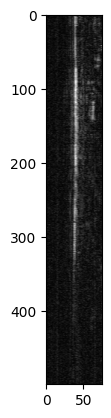

In [167]:
plt.imshow(original_data[:,UP_flat:DOWN_flat,static_flat],cmap='gray')

# Y-motion

In [168]:

def mse_fun_tran_y(shif, x, y , past_shift):
    x = warp(x, AffineTransform(translation=(0,-past_shift)),order=3)
    y = warp(y, AffineTransform(translation=(0,past_shift)),order=3)

    warped_x_stat = warp(x, AffineTransform(translation=(0,-shif[0])),order=3)
    warped_y_mov = warp(y, AffineTransform(translation=(0,shif[0])),order=3)

    return (1-ncc(warped_x_stat ,warped_y_mov))
    
def ants_all_trans_y(data,UP_y,DOWN_y,static_y_motion):
    transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(data.shape[0]-1),desc='tr_all'):
        stat = data[static_y_motion][UP_y:DOWN_y][:,::20].copy()
        temp_img = data[i][UP_y:DOWN_y][:,::20].copy()
        # MANUAL
        # temp_tform_manual = AffineTransform(translation=(0,0))
        past_shift = 0
        for _ in range(10):
            move = minz(method='powell',fun = mse_fun_tran_y,x0 =(0), bounds=[(-2,2)],
                        args = (stat
                                ,temp_img
                                ,past_shift))['x']

            past_shift += move[0]
        temp_tform_manual = AffineTransform(matrix = AffineTransform(translation=(0,past_shift*2)))
        transforms_all[i] = np.dot(transforms_all[i],temp_tform_manual)
    return transforms_all


In [169]:
def y_motion_correcting(data,UP_y,DOWN_y,top_surf):
    static_y_motion = np.argmax(np.sum(data[:,UP_y:DOWN_y,:],axis=(1,2)))
    # finding the bright points in all images in standard interference
    nn = [np.argmax(np.sum(data[i][UP_y:DOWN_y],axis=1)) for i in range(data.shape[0])]
    tf_all_nn = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in range(tf_all_nn.shape[0]):
        tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
    if top_surf:
        for i in tqdm(range(data.shape[0]),desc='warping'):
            data[i,:DOWN_y]  = warp(data[i,:DOWN_y],AffineTransform(matrix=tf_all_nn[i]),order=3)
    else:
        for i in tqdm(range(data.shape[0]),desc='warping'):
            data[i,UP_y:]  = warp(data[i,UP_y:],AffineTransform(matrix=tf_all_nn[i]),order=3)

    tr_all_y = ants_all_trans_y(data,UP_y,DOWN_y,static_y_motion)
    if top_surf:
        for i in tqdm(range(data.shape[0]),desc='warping'):
            data[i,:DOWN_y]  = warp(data[i,:DOWN_y],AffineTransform(matrix=tr_all_y[i]),order=3)
    else:
        for i in tqdm(range(data.shape[0]),desc='warping'):
            data[i,UP_y:]  = warp(data[i,UP_y:],AffineTransform(matrix=tr_all_y[i]),order=3)
    return data

In [170]:
# UP,DOWN = enface_extraction_rows.min()-50,enface_extraction_rows.min()+50
# UP = max(UP,0)
# DOWN = min(DOWN, original_data.shape[2])
# UP,DOWN
# original_data = y_motion_correcting(original_data,UP,DOWN)

# UP,DOWN = enface_extraction_rows.max()-30,enface_extraction_rows.max()+30
# UP = max(UP,0)
# DOWN = min(DOWN, original_data.shape[2])
# UP,DOWN
# original_data = y_motion_correcting(original_data,UP,DOWN)

if surface_coords.ndim==1:
    surface_coords = surface_coords.reshape(1,-1)
top_surf = True
for i in range(surface_coords.shape[0]):
    UP_y,DOWN_y = surface_coords[i][0], surface_coords[i][1]
    UP_y = max(UP_y,0)
    DOWN_y = min(DOWN_y, original_data.shape[2])
    original_data = y_motion_correcting(original_data,UP_y,DOWN_y,top_surf)
    top_surf = False

warping: 100%|██████████| 500/500 [00:09<00:00, 50.73it/s]


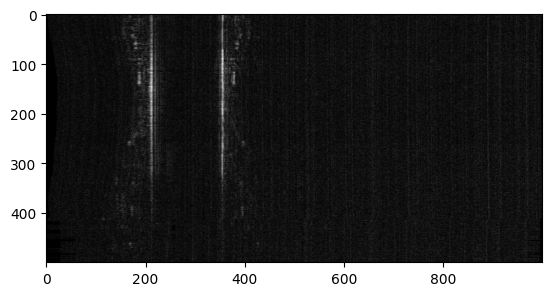

In [171]:

plt.imshow(original_data[:,:,static_flat],cmap='gray')

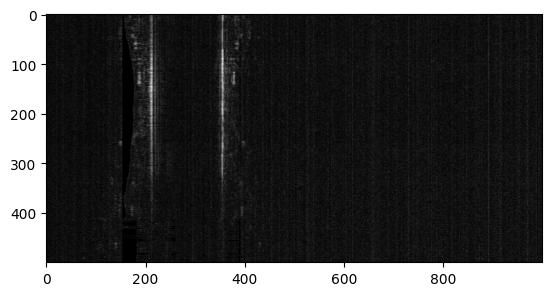

In [151]:

plt.imshow(original_data[:,:,static_flat],cmap='gray')

# X-motion

In [152]:
test_detect_img = preprocess_img(original_data[:,:,static_flat])
res = model.predict(test_detect_img,iou = 0.5, save = False, verbose=False,classes=[0,1])
result_list = res[0].summary()

grouped = defaultdict(list)
for item in result_list:
    grouped[item['name']].append(item)

filtered_summary = []
for group in grouped.values():
    top_two = sorted(group, key=lambda x: x['confidence'], reverse=True)[:2]
    filtered_summary.extend(top_two)
 
result_list = filtered_summary

In [129]:
import gc
def shift_func(shif, x, y , past_shift):
    x = scp.shift(x, -past_shift,order=3,mode='nearest')
    y = scp.shift(y, past_shift,order=3,mode='nearest')

    warped_x_stat = scp.shift(x, -shif[0],order=3,mode='nearest')
    warped_y_mov = scp.shift(y, shif[0],order=3,mode='nearest')

    return (1-ncc1d(warped_x_stat ,warped_y_mov))

def ncc1d(array1, array2):
    correlation = np.correlate(array1, array2, mode='valid')
    array1_norm = np.linalg.norm(array1)
    array2_norm = np.linalg.norm(array2)
    if array1_norm == 0 or array2_norm == 0:
        return np.zeros_like(correlation)
    normalized_correlation = correlation / (array1_norm * array2_norm)
    return normalized_correlation

def mse_fun_tran_x(shif, x, y , past_shift):
    x = warp(x, AffineTransform(translation=(-past_shift,0)),order=3)
    y = warp(y, AffineTransform(translation=(past_shift,0)),order=3)

    warped_x_stat = warp(x, AffineTransform(translation=(-shif[0],0)),order=3)
    warped_y_mov = warp(y, AffineTransform(translation=(shif[0],0)),order=3)

    return (1-ncc(warped_x_stat ,warped_y_mov))

def get_line_shift(line_1d_stat, line_1d_mov,enface_shape):
    # grad_feat = np.argmax(np.abs(np.gradient(line_1d_stat)[5:-5]))+5
    # # print(grad_feat,i)
    # grad_feat = max(20,grad_feat)
    # grad_feat = min(grad_feat,enface_shape-20)
    # st = line_1d_stat[grad_feat-20:grad_feat+20]
    # mv = line_1d_mov[grad_feat-20:grad_feat+20]
    st = line_1d_stat
    mv = line_1d_mov
    past_shift = 0
    for _ in range(10):
        move = minz(method='powell',fun = shift_func,x0 = (0),bounds =[(-5,5)],
                args = (st
                        ,mv
                        ,past_shift))['x']
        past_shift += move[0]
    return past_shift*2

def check_best_warp(stat, mov, value, is_shift_value = False):
    # if is_shift_value:
    err = ncc(stat,warp(mov, AffineTransform(translation=(-value,0)),order=3))
    return err
    # err = ncc(stat,warp(mov, AffineTransform(matrix=value),order=3))
    # return err

def check_multiple_warps(stat_img, mov_img, *args):
    errors = []
    warps = args[0]
    # errors.append(check_best_warp(stat_img, mov_img, warps[0], is_shift_value = False))
    for warp_value in range(len(warps)):
        errors.append(check_best_warp(stat_img, mov_img, warps[warp_value]))
    # print(errors)
    return np.argmax(errors)

def ants_all_trans_x(data,UP_x,DOWN_x,valid_args,enface_extraction_rows):
    transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(0,data.shape[0]-1,2),desc='tr_all'):
        if i not in valid_args:
            continue

        if len(UP_x) and len(DOWN_x)>1:
            stat = data[i,np.r_[UP_x[0]:DOWN_x[0],UP_x[1]:DOWN_x[1]]].copy()
            temp_manual = data[i+1,np.r_[UP_x[0]:DOWN_x[0],UP_x[1]:DOWN_x[1]]].copy()
        else:
            stat = data[i,UP_x:DOWN_x].copy()
            temp_manual = data[i+1,UP_x:DOWN_x].copy()
        # MANUAL
        temp_tform_manual = AffineTransform(translation=(0,0))
        past_shift = 0
        for _ in range(10):
            move = minz(method='powell',fun = mse_fun_tran_x,x0 =(0), bounds=[(-5,5)],
                        args = (stat
                                ,temp_manual
                                ,past_shift))['x']

            past_shift += move[0]
        cross_section = -(past_shift*2)

        # temp_tform_manual = AffineTransform(matrix = AffineTransform(translation=(past_shift*2,0)))
        # transforms_all[i] = np.dot(transforms_all[i],temp_tform_manual)

        enface_shape = original_data[:,0,:].shape[1]
        enface_wraps = []
        for enf_idx in range(len(enface_extraction_rows)):
            temp_enface_shift = get_line_shift(data[i,enface_extraction_rows[enf_idx]],data[i+1,enface_extraction_rows[enf_idx]],enface_shape)
            enface_wraps.append(temp_enface_shift)
        # enface_line_standard = get_line_shift(data[i,enface_extraction_rows[0]],data[i+1,enface_extraction_rows[0]],enface_shape)
        # enface_line_endo = get_line_shift(data[i,800],data[i+1,800],enface_shape)
        # enface_line_self = get_line_shift(data[i,enface_extraction_rows],data[i+1,enface_extraction_rows],enface_shape)

        all_warps = [cross_section,*enface_wraps]
        best_warp = check_multiple_warps(data[i], data[i+1], all_warps)

        temp_tform_manual = AffineTransform(translation=(-(all_warps[best_warp]),0))
        transforms_all[i+1] = np.dot(transforms_all[i+1],temp_tform_manual)
        gc.collect()

    return transforms_all


In [77]:
# sum_img = np.max(original_data[:,:,:],axis=2)
# peaks = find_peaks(np.sum(sum_img,axis=0),distance = 30)[0]
# enface_extraction_rows = peaks[np.argsort(np.sum(sum_img,axis=0)[peaks])[-2:]]
# enface_extraction_rows = np.sort(enface_extraction_rows)
# print('ROWS:',enface_extraction_rows)
# UP_x,DOWN_x = enface_extraction_rows.min()-50, enface_extraction_rows.min()-10
# UP_x = max(UP_x,0)
# DOWN_x = min(DOWN_x, original_data.shape[2])


In [130]:
if len(result_list)>0:
    surface_coords = []
    cells_coords = []
    for detections in result_list:
        if detections['name'] == 'surface':
            surface_coords.append([int(detections['box']['y1'])-20,int(detections['box']['y2'])+20])
        if detections['name'] == 'cells':
            cells_coords.append([int(detections['box']['y1'])-20,int(detections['box']['y2'])+20])
    if len(surface_coords)>1:
        surface_coords = np.sort(surface_coords,axis=0)
    if len(cells_coords)>1:
        cells_coords = np.sort(cells_coords,axis=0)

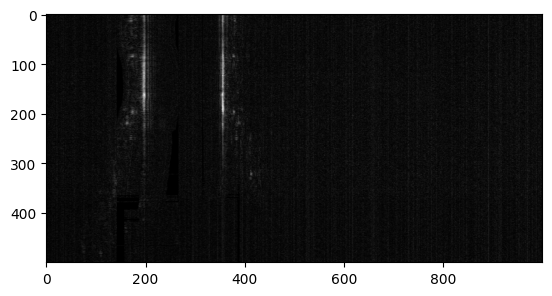

In [ ]:
static_y_motion = np.argmax(np.sum(original_data[:,surface_coords[0,0]:surface_coords[0,1],:],axis=(1,2)))
errs = []
for i in range(original_data.shape[0]):
    errs.append(ncc(original_data[static_y_motion,:,:],original_data[i,:,:])[0])
errs = np.squeeze(errs)
valid_args = np.squeeze(np.argwhere(errs>0.7))
# print(static_y_motion)

plt.imshow(original_data[:,:,100],cmap='gray')

In [132]:
if cells_coords.ndim==1:
    cells_coords = cells_coords.reshape(1,-1)

if cells_coords.shape[0]==1:
    UP_x, DOWN_x = cells_coords[0][0], cells_coords[0][1]
else:
    UP_x, DOWN_x = (cells_coords[:,0]), (cells_coords[:,1])
UP_x, DOWN_x


if surface_coords.ndim==1:
    surface_coords = surface_coords.reshape(1,-1)
enface_extraction_rows = []
if surface_coords.shape[0]==1:
    val = np.argmax(np.sum(np.max(original_data[:,surface_coords[0,0]:surface_coords[0,1],:],axis=0),axis=1))
    enface_extraction_rows.append(val)
else:
    for i in range(surface_coords.shape[0]):
        val = np.argmax(np.sum(np.max(original_data[:,surface_coords[i,0]:surface_coords[i,1],:],axis=0),axis=1))
        enface_extraction_rows.append(val)

In [ ]:
# errs = []
# for i in range(original_data.shape[0]):
#     errs.append(ncc(original_data[static_y_motion,:,:],original_data[i,:,:])[0])
# errs = np.squeeze(errs)
# valid_args = np.squeeze(np.argwhere(errs>0.7))

In [133]:
tr_all = ants_all_trans_x(original_data,UP_x,DOWN_x,valid_args,enface_extraction_rows)

tr_all: 100%|██████████| 250/250 [21:39<00:00,  5.20s/it] 


In [134]:
gg = original_data.copy()
for i in tqdm(range(1,gg.shape[0],2),desc='warping'):
    gg[i]  = warp(gg[i],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 250/250 [00:08<00:00, 29.04it/s]


In [135]:
folder_save = 'test'
os.makedirs(folder_save,exist_ok=True)
for i,j in tqdm(enumerate(gg)):
    cv2.imwrite(f'{folder_save}/'+f'frame_test{i}.PNG',j)

0it [00:00, ?it/s][ WARN:0@6104.407] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.
500it [00:02, 168.86it/s]


# VISUALS

In [206]:
model = YOLO('/Users/akapatil/Documents/feature_extraction/yolo_feature_extraction/yolov12s_best.pt')
def give_enface(scan_num):
    path = f'registered_endo/{scan_num}'
    # path = 'intervolume_registered/self_inter/scan5/'
    # pic_paths = []
    # for i in os.listdir(path):
    #     if i.endswith('.h5'):
    #         pic_paths.append(i)
    with h5py.File(path, 'r') as hf:
        original_data = hf['volume'][:]

    static_flat = np.argmax(np.sum(original_data[:,:,:],axis=(0,1)))
    test_detect_img = preprocess_img(original_data[:,:,static_flat])
    res = model.predict(test_detect_img,iou = 0.5, save = False, verbose=False,classes=0)
    result_list = res[0].summary()
    grouped = defaultdict(list)
    for item in result_list:
        grouped[item['name']].append(item)
    filtered_summary = []
    for group in grouped.values():
        top_two = sorted(group, key=lambda x: x['confidence'], reverse=True)[:2]
        filtered_summary.extend(top_two)
    result_list = filtered_summary
    surface_coords= []
    for detections in result_list:
        if detections['name'] == 'surface':
            surface_coords.append([int(detections['box']['y1'])-10,int(detections['box']['y2'])+10])
    if len(surface_coords)>1:
        surface_coords = np.sort(surface_coords,axis=0)
    surface_coords = np.squeeze(np.array(surface_coords))
    surface_coords = np.where(surface_coords<0,0,surface_coords)
    if len(result_list)==0:
        print(f'NO SURFACE DETECTED: {scan_num}')
        return original_data[:,0,:]
    print(surface_coords[1])
    val = np.argmax(np.sum(np.max(original_data[:,surface_coords[1,0]:surface_coords[1,1],:],axis=0),axis=1))
    print(val)
    # enface_extraction_rows.append(val)
    # val = np.argmax(np.sum(np.max(original_data[:,:,:],axis=0),axis=1))
    # sum_img = np.max(original_data[:,:,:],axis=2)
    # peaks = find_peaks(np.sum(sum_img,axis=0),distance = 10)[0]
    # enface_extraction_rows = peaks[np.argsort(np.sum(sum_img,axis=0)[peaks])[-1]]
    # row = enface_extraction_rows.max()
    return original_data[:,val,:]

In [207]:
reg_dir = os.listdir('registered_endo/')
reg_dir = natsorted(reg_dir)
with h5py.File('registered_endo/'+reg_dir[0], 'r') as hf:
    shape_data = hf['volume'].shape

enfaces = np.empty((len(reg_dir),shape_data[0],shape_data[2]))
for i in tqdm(range(enfaces.shape[0])):
    enfaces[i] = give_enface(reg_dir[i])

  0%|          | 0/13 [00:00<?, ?it/s]

  8%|▊         | 1/13 [00:11<02:22, 11.90s/it]

[325 382]
31


 15%|█▌        | 2/13 [00:22<02:01, 11.01s/it]

[325 381]
30


 23%|██▎       | 3/13 [00:32<01:48, 10.84s/it]

[328 383]
29


 31%|███       | 4/13 [00:42<01:33, 10.34s/it]

[327 384]
31


 38%|███▊      | 5/13 [00:51<01:19,  9.96s/it]

[328 382]
30


 46%|████▌     | 6/13 [01:01<01:10, 10.03s/it]

[328 386]
32


 46%|████▌     | 6/13 [01:12<01:24, 12.06s/it]

73


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
folder_save = 'enfaces_endo'
os.makedirs(folder_save,exist_ok=True)
for i,j in tqdm(enumerate(enfaces)):
    cv2.imwrite(f'{folder_save}/'+f'frame_test{i}.PNG',j)

13it [00:00, 339.71it/s]


In [201]:
def merge_intervals(intervals):
    if not intervals:
        return []
    intervals.sort(key=lambda x: x[0])
    merged = [intervals[0]]
    for current in intervals[1:]:
        last = merged[-1]
        if current[0] <= last[1]:  # overlap
            last[1] = max(last[1], current[1])  # merge
        else:
            merged.append(current)
    return merged


In [295]:
a = np.array([[1,2],[5,10]])
b = np.array([[4,30]])

In [292]:
merged_coords = []
if a is not None:
    a[:,0],a[:,1] = a[:,0]-30, a[:,1]+30
    a = np.where(a<0,0,a)
    merged_coords.extend([*a])
if b is not None:
    b[:,0],b[:,1] = b[:,0]-30, b[:,1]+30
    b = np.where(b<0,0,b)
    merged_coords.extend([*b])

In [293]:
merged_coords

[array([ 0, 32]), array([ 0, 40]), array([ 0, 60])]

In [294]:
merge_intervals([*merged_coords])

[array([ 0, 60])]

In [233]:
np.r_[tuple(np.r_[start:end] for start, end in merged)]

array([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [334]:
from tqdm import tqdm
import time

pbar = tqdm(range(int(9e6)), desc="Initial Description", ascii="░▖▘▝▗▚▞█")

for i in pbar:
    pass
print("Finished!")

Initial Description: 100%|██████████| 9000000/9000000 [00:01<00:00, 7199001.76it/s]

Finished!


In [381]:
a = np.zeros((100,100,100))

In [406]:
1 - ncc(np.array([[5,5],[5,5]]),np.array([[2,2],[5,5]]))

array([[   0.080855]])

In [ ]:
(ncc(np.array([[5,5],[5,5]]),np.array([[2,2],[5,5]]))))

0.9191450300180578